# Reconocimiento facial por edades

## Introducción

La cadena de supermercados Good Seed ha comprendido la importancia de respetar las leyes que prohíben la venta de alcohol a menores. Para hacer frente a este desafío, están considerando el uso de la ciencia de datos y la visión artificial para verificar la edad de los clientes que compran alcohol. Este proyecto se enfoca en desarrollar y evaluar un modelo de aprendizaje automático capaz de estimar la edad de las personas a partir de imágenes tomadas por las cámaras en las cajas registradoras. A través del análisis detallado de los datos y la aplicación de un modelo visual, se busca ofrecer a Good Seed una solución efectiva para cumplir con las normativas sobre ventas de alcohol y fomentar la seguridad pública.

## Inicialización

In [1]:
# Importa las librerias
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy as np
import tensorflow as tf 
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img
import inspect

## Carga los datos

In [2]:
# Inicialización y carga de datos
path = 'files/datasets/input/faces/'
directory = path + 'final_files/'
labels = pd.read_csv(path + "labels.csv")

In [3]:
# Crea un generador de imágenes
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
         dataframe= labels,
         directory= directory,
         x_col='file_name',
         y_col='real_age',
         target_size=(224, 224),
         batch_size=32,
         class_mode='raw',
         seed=12345)

Found 7591 validated image filenames.


In [4]:
# Obtiene un lote de imágenes y etiquetas
image_arrays, age_array = train_gen_flow.next()

## EDA

In [5]:
# Información de las etiquetas
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
# Muestra los primeros registros
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [7]:
# Tamaño del conjunto de datos
print("Tamaño del conjunto de datos:", labels.shape)

Tamaño del conjunto de datos: (7591, 2)


In [8]:
# Descripción estadística de la edad
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


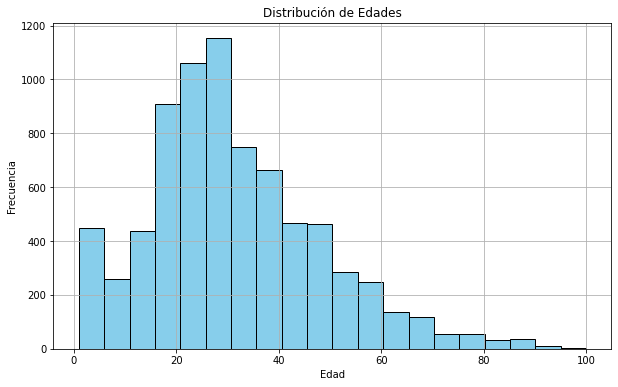

In [9]:
# Explora la distribución de edad
plt.figure(figsize=(10, 6))
plt.hist(labels['real_age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribución de Edades')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

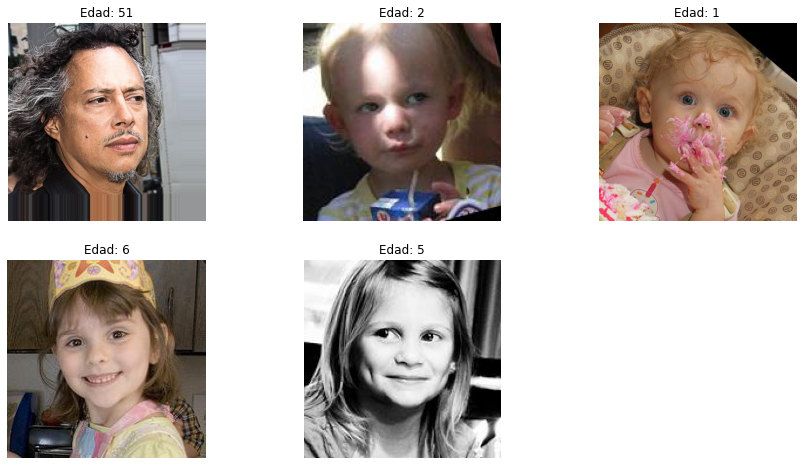

In [10]:
# Imprime algunas fotos para diferentes edades
unique_ages = labels['real_age'].unique()

# Selecciona algunas edades para mostrar
sample_ages = unique_ages[10:15]  

plt.figure(figsize=(15, 8))
for i, age in enumerate(sample_ages):
    plt.subplot(2, 3, i+1)
    file = labels[labels['real_age'] == age]['file_name'].iloc[0]
    img = load_img('/datasets/faces/final_files/' + file)
    plt.imshow(img)
    plt.title(f'Edad: {age}')
    plt.axis('off')
plt.show()

### Conclusiones

Después de explorar los datos de imágenes faciales, se llegaron a las siguientes conclusiones importantes:

El conjunto de datos consta de 7591 imágenes faciales junto con sus respectivas etiquetas de edad. Se observa una distribución sesgada hacia edades más jóvenes, lo que implica que el conjunto de datos puede estar desequilibrado en términos de representación de diferentes grupos de edad.

La distribución de edades muestra una concentración mayor de imágenes en edades más jóvenes, con una disminución gradual en la frecuencia a medida que aumenta la edad. Esta distribución desigual puede influir en el rendimiento del modelo y requerir estrategias específicas durante el entrenamiento y la evaluación del modelo.

Al examinar las imágenes visuales para diferentes edades, se observa una variedad de condiciones de iluminación y calidad de imagen. Esto destaca la necesidad de considerar técnicas de preprocesamiento para mejorar la robustez del modelo frente a estas variabilidades en las condiciones de imagen.

## Modelado

In [11]:
def load_train(path):
    """
    Carga el conjunto de datos de entrenamiento.
    """
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1.0/255
                                )

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + "labels.csv"),
        directory=path +'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16, # 32
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return train_gen_flow

In [12]:
def load_test(path):
    """
    Carga el conjunto de datos de prueba.
    """
    test_datagen = ImageDataGenerator(
        validation_split=0.25, rescale=1.0/255
    )

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + "labels.csv"),
        directory=path +'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16, # 32
        class_mode='raw',
        subset='validation',
        seed=12345
    )

    return test_gen_flow

In [13]:
def create_model(input_shape):
    """
    Define el modelo utilizando la arquitectura ResNet50.
    """
    backbone = ResNet50(
        input_shape=input_shape, #(224, 224, 3),
        weights='imagenet',
        include_top=False
    )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    #model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

    model.compile(
        loss='mse',
        optimizer=Adam(learning_rate=0.0001), # default is 0.001
        metrics=['mae']
    )

    print(model.summary())
    return model

In [14]:
def train_model(model, 
                train_data, 
                test_data, 
                epochs=5, 
                batch_size=None, 
                steps_per_epoch=None, 
                validation_steps=None):
    """
    Entrena el modelo utilizando los datos de entrenamiento y validación.
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    """
    Entrena el modelo con los parametros dados
    """

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2
    )

    return model

## Prepara el script para ejecutarlo en la plataforma GPU

In [15]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### El resultado

2024-03-31 13:23:00.356901: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2024-03-31 13:23:00.423401: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 7591 validated image filenames.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #  Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
Tamaño del conjunto de datos: (7591, 2)
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2024-03-31 13:23:09.544748: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-03-31 13:23:09.664851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:09.665075: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2024-03-31 13:23:09.665121: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-03-31 13:23:09.665159: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-03-31 13:23:09.728982: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-03-31 13:23:09.745734: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-03-31 13:23:09.913591: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-03-31 13:23:09.939459: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-03-31 13:23:09.939531: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-03-31 13:23:09.939663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:09.939935: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:09.940089: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2024-03-31 13:23:09.940473: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-03-31 13:23:09.972574: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2024-03-31 13:23:09.974049: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5647d80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-03-31 13:23:09.974075: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-03-31 13:23:10.167273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:10.167560: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55506d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-31 13:23:10.167580: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-03-31 13:23:10.167786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:10.167950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2024-03-31 13:23:10.167984: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-03-31 13:23:10.167995: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-03-31 13:23:10.168031: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-03-31 13:23:10.168045: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-03-31 13:23:10.168063: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-03-31 13:23:10.168079: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-03-31 13:23:10.168096: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-03-31 13:23:10.168158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:10.168335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:10.168463: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2024-03-31 13:23:10.169638: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-03-31 13:23:12.278053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-03-31 13:23:12.278101: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2024-03-31 13:23:12.278114: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2024-03-31 13:23:12.282842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:12.283102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:12.283289: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-03-31 13:23:12.283327: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14988 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0)
2024-03-31 13:23:00.356901: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2024-03-31 13:23:00.423401: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 7591 validated image filenames.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
Tamaño del conjunto de datos: (7591, 2)
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2024-03-31 13:23:09.544748: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-03-31 13:23:09.664851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:09.665075: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2024-03-31 13:23:09.665121: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-03-31 13:23:09.665159: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-03-31 13:23:09.728982: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-03-31 13:23:09.745734: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-03-31 13:23:09.913591: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-03-31 13:23:09.939459: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-03-31 13:23:09.939531: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-03-31 13:23:09.939663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:09.939935: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:09.940089: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2024-03-31 13:23:09.940473: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-03-31 13:23:09.972574: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2024-03-31 13:23:09.974049: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5647d80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-03-31 13:23:09.974075: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-03-31 13:23:10.167273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:10.167560: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55506d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-31 13:23:10.167580: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-03-31 13:23:10.167786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:10.167950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2024-03-31 13:23:10.167984: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-03-31 13:23:10.167995: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-03-31 13:23:10.168031: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-03-31 13:23:10.168045: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-03-31 13:23:10.168063: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-03-31 13:23:10.168079: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-03-31 13:23:10.168096: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-03-31 13:23:10.168158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:10.168335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:10.168463: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2024-03-31 13:23:10.169638: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-03-31 13:23:12.278053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-03-31 13:23:12.278101: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2024-03-31 13:23:12.278114: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2024-03-31 13:23:12.282842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:12.283102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:12.283289: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-03-31 13:23:12.283327: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14988 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 1s
11427840/94765736 [==>...........................] - ETA: 0s
23805952/94765736 [======>.......................] - ETA: 0s
36110336/94765736 [==========>...................] - ETA: 0s
48431104/94765736 [==============>...............] - ETA: 0s
60940288/94765736 [==================>...........] - ETA: 0s
73383936/94765736 [======================>.......] - ETA: 0s
85925888/94765736 [==========================>...] - ETA: 0s
94773248/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
None
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/5
2024-03-31 13:23:28.366460: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-03-31 13:23:29.409127: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 64s - loss: 193.2228 - mae: 10.0870 - val_loss: 456.3945 - val_mae: 16.2526
Epoch 2/5
356/356 - 38s - loss: 67.8501 - mae: 6.2722 - val_loss: 184.1761 - val_mae: 10.9159
Epoch 3/5
356/356 - 38s - loss: 36.7607 - mae: 4.7012 - val_loss: 73.8095 - val_mae: 6.4553
Epoch 4/5
356/356 - 38s - loss: 24.1685 - mae: 3.8005 - val_loss: 89.0847 - val_mae: 7.0927
Epoch 5/5
356/356 - 38s - loss: 16.8487 - mae: 3.1690 - val_loss: 80.0771 - val_mae: 6.5383
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 80.0771 - mae: 6.5383
Test MAE: 6.5383
2024-03-31 13:23:00.356901: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2024-03-31 13:23:00.423401: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 7591 validated image filenames.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
Tamaño del conjunto de datos: (7591, 2)
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2024-03-31 13:23:09.544748: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-03-31 13:23:09.664851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:09.665075: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2024-03-31 13:23:09.665121: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-03-31 13:23:09.665159: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-03-31 13:23:09.728982: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-03-31 13:23:09.745734: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-03-31 13:23:09.913591: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-03-31 13:23:09.939459: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-03-31 13:23:09.939531: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-03-31 13:23:09.939663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:09.939935: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:09.940089: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2024-03-31 13:23:09.940473: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-03-31 13:23:09.972574: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2024-03-31 13:23:09.974049: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5647d80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-03-31 13:23:09.974075: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-03-31 13:23:10.167273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:10.167560: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55506d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-31 13:23:10.167580: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-03-31 13:23:10.167786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:10.167950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2024-03-31 13:23:10.167984: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-03-31 13:23:10.167995: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-03-31 13:23:10.168031: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-03-31 13:23:10.168045: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-03-31 13:23:10.168063: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-03-31 13:23:10.168079: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-03-31 13:23:10.168096: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-03-31 13:23:10.168158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:10.168335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:10.168463: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2024-03-31 13:23:10.169638: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-03-31 13:23:12.278053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-03-31 13:23:12.278101: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2024-03-31 13:23:12.278114: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2024-03-31 13:23:12.282842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:12.283102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-31 13:23:12.283289: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-03-31 13:23:12.283327: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14988 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 1s
11427840/94765736 [==>...........................] - ETA: 0s
23805952/94765736 [======>.......................] - ETA: 0s
36110336/94765736 [==========>...................] - ETA: 0s
48431104/94765736 [==============>...............] - ETA: 0s
60940288/94765736 [==================>...........] - ETA: 0s
73383936/94765736 [======================>.......] - ETA: 0s
85925888/94765736 [==========================>...] - ETA: 0s
94773248/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
None
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/5
2024-03-31 13:23:28.366460: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-03-31 13:23:29.409127: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 64s - loss: 193.2228 - mae: 10.0870 - val_loss: 456.3945 - val_mae: 16.2526
Epoch 2/5
356/356 - 38s - loss: 67.8501 - mae: 6.2722 - val_loss: 184.1761 - val_mae: 10.9159
Epoch 3/5
356/356 - 38s - loss: 36.7607 - mae: 4.7012 - val_loss: 73.8095 - val_mae: 6.4553
Epoch 4/5
356/356 - 38s - loss: 24.1685 - mae: 3.8005 - val_loss: 89.0847 - val_mae: 7.0927
Epoch 5/5
356/356 - 38s - loss: 16.8487 - mae: 3.1690 - val_loss: 80.0771 - val_mae: 6.5383
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 80.0771 - mae: 6.5383
Test MAE: 6.5383

## Conclusiones

El conjunto de datos comprende 7591 imágenes faciales junto con etiquetas de edad. Al explorar estos datos, se observa una distribución sesgada hacia edades más jóvenes, lo que sugiere un posible desequilibrio en la representación de diferentes grupos de edad. La concentración de imágenes en edades más jóvenes es notable, disminuyendo gradualmente en frecuencia a medida que aumenta la edad.

Para abordar este problema y preparar los datos para el modelado, se ha utilizado una técnica de preprocesamiento de imágenes conocida como generación de imágenes (ImageDataGenerator). Esto ha implicado redimensionar las imágenes a un tamaño estándar de 224x224 píxeles y normalizarlas dividiendo cada píxel por 255.

El modelo de predicción de edad se ha construido utilizando la arquitectura ResNet50 preentrenada, una red neuronal convolucional profunda ampliamente utilizada en aplicaciones de visión por computadora. Este modelo consta de una capa base ResNet50 seguida de una capa de Global Average Pooling y una capa densa de salida con activación ReLU. Se ha optado por el error cuadrático medio (MSE) como función de pérdida y el optimizador Adam con una tasa de aprendizaje de 0.0001.

Para evaluar el rendimiento del modelo, se ha entrenado durante 5 épocas utilizando un tamaño de lote de 16 y un conjunto de datos de entrenamiento y validación. Durante el entrenamiento, se han registrado métricas como la pérdida (MSE) y el error absoluto medio (MAE) tanto en el conjunto de entrenamiento como en el de validación.

Finalmente, después del entrenamiento, se ha evaluado el modelo en un conjunto de datos de prueba separado. El resultado obtenido fue un MAE de 6.5383, lo que indica que el modelo puede predecir la edad con un error medio absoluto razonable en este conjunto de datos. Sin embargo, hay espacio para explorar mejoras adicionales, especialmente para abordar el posible desequilibrio en la distribución de edades y mejorar la precisión general del modelo.